In [12]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle

In [13]:
# target = "target_close"
# target = "close_percent_change_1"
target = "up_down_close_1"

In [14]:
# Load model
# model = pickle.load(open("../model/xgboost_model.pkl", "rb"))

try:
    model = xgb.XGBRegressor()
    model.load_model("../model/xgboost_model.json")
except:
    model = xgb.XGBClassifier()
    model.load_model("../model/xgboost_model.json")

In [15]:
# print features name
print(len(model.get_booster().feature_names))
model.get_booster().get_score()

327


{'open': 23.0,
 'high': 15.0,
 'low': 12.0,
 'close': 14.0,
 'adj close': 5.0,
 'volume': 81.0,
 'volitility_open_7': 81.0,
 'volitility_pct_change_7_open': 132.0,
 'high_low_7': 74.0,
 'high_close_7': 123.0,
 'low_close_7': 125.0,
 'true_range_7': 76.0,
 'average_true_range_7': 46.0,
 'open_rolling_mean_7': 6.0,
 'open_rolling_exp_mean_7': 9.0,
 'rsi_7': 184.0,
 'short_ema_12': 39.0,
 'long_ema_26': 36.0,
 'macd_12_26': 88.0,
 'signal_9': 113.0,
 'macd_hist_12_26_9': 129.0,
 'stochastic_oscillator_7': 178.0,
 'williams_r_7': 121.0,
 'on_balance_volume_1': 134.0,
 'volume_weighted_average_price_7': 3.0,
 'open_rolling_std_7': 50.0,
 'open_bollinger_upper_7': 6.0,
 'open_bollinger_lower_7': 1.0,
 'open_fib_0.236': 4.0,
 'open_fib_0.382': 2.0,
 'open_fib_0.618': 2.0,
 'open_fib_1.0': 2.0,
 'volitility_open_14': 71.0,
 'volitility_pct_change_14_open': 93.0,
 'high_low_14': 52.0,
 'high_close_14': 94.0,
 'low_close_14': 91.0,
 'true_range_14': 48.0,
 'average_true_range_14': 43.0,
 'open_r

In [16]:
# load predictions
df = pd.read_parquet("../data/predicted.parquet")

In [17]:
def normalize_column(data: pd.DataFrame, column: str | list) -> pd.DataFrame:
    if isinstance(column, str):
        data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())
    elif isinstance(column, list):
        for col in column:
            data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
    return data

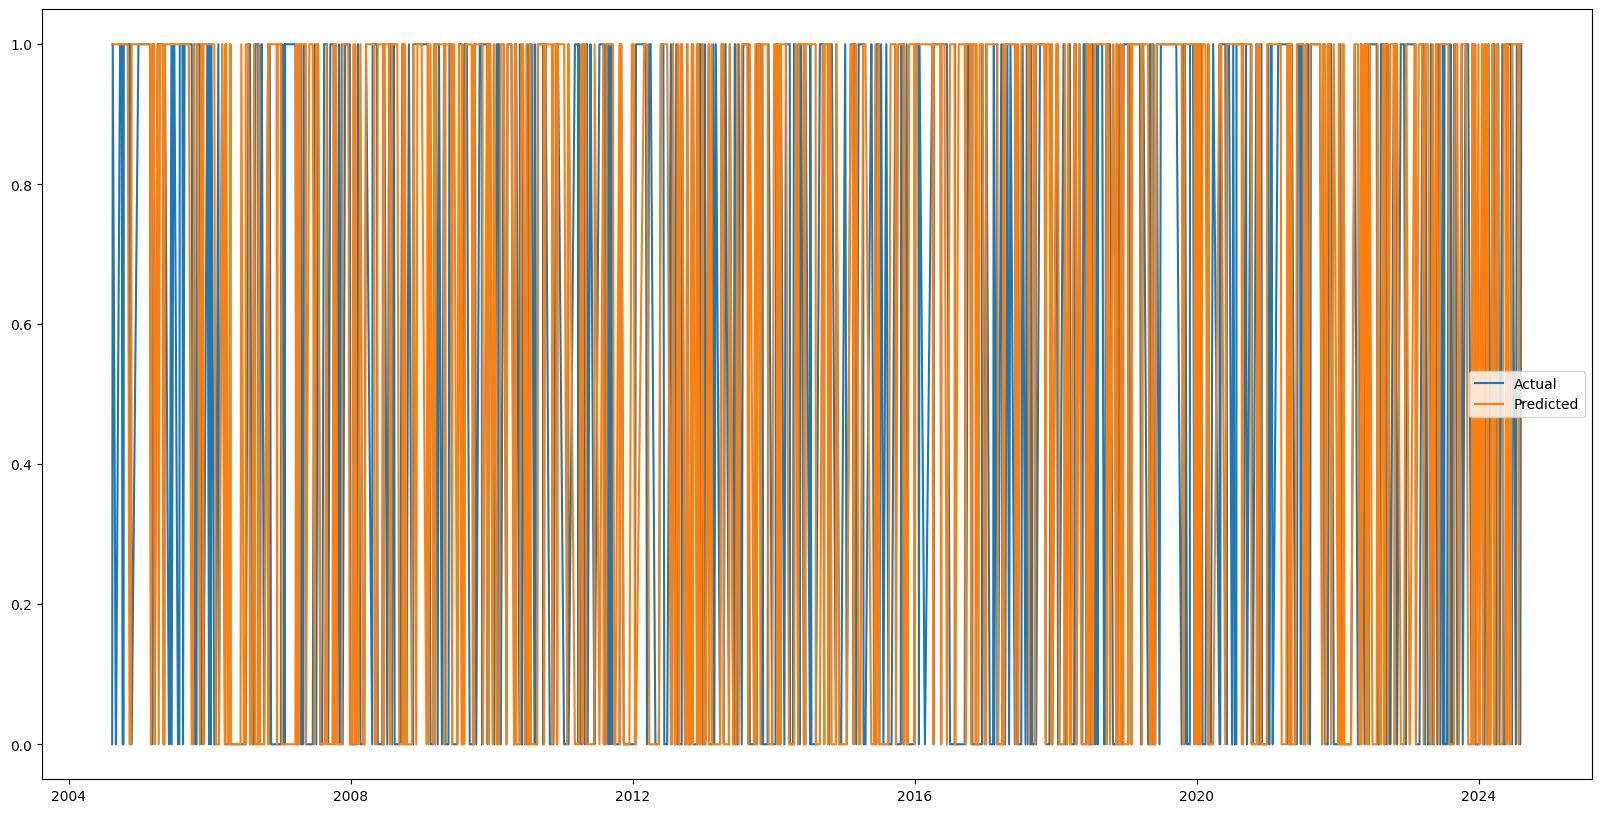

In [18]:
# Plot the predicted vs actual values
plt.figure(figsize=(20, 10))
plt.plot(df[target], label="Actual")
plt.plot(df["predicted"], label="Predicted")
plt.legend()
plt.show()

<Axes: xlabel='date', ylabel='value'>

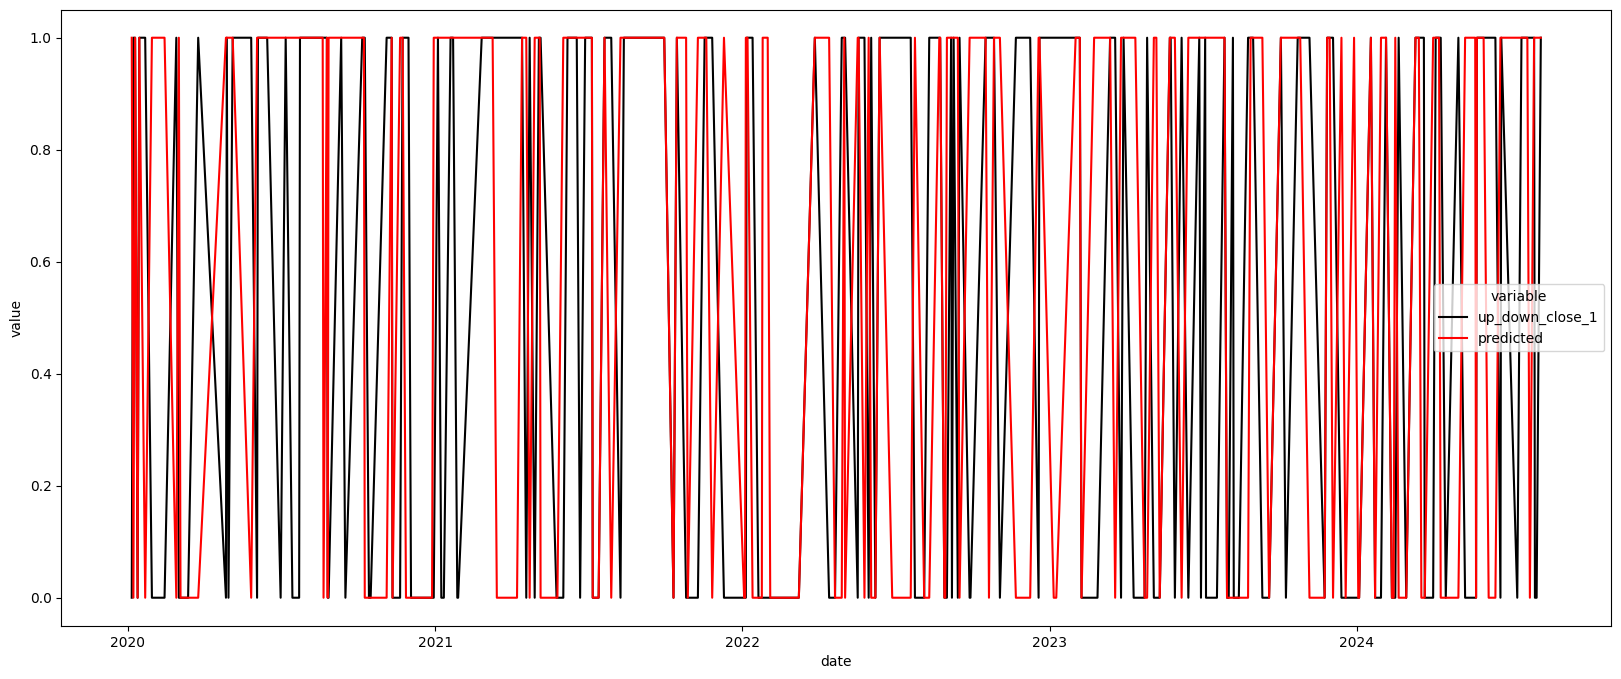

In [19]:
fig, ax = plt.subplots(figsize=(20, 8))
# Only 2008 - 2012 indexs 
df_date = df.loc["2020":"2024"]

sns.lineplot(
    df_date.reset_index().melt(id_vars=["date"], value_vars=[target, "predicted"]),
    y="value",
    x="date",
    hue="variable",
    linewidth=1.5,
    palette=['black', 'red'],
    ax=ax,
)

In [20]:
df_importance = pd.DataFrame()

importance_types = ["weight", "gain", "cover", "total_gain", "total_cover"]
for importance_type in importance_types:
    importance = model.get_booster().get_score(importance_type=importance_type)

    df_i = pd.DataFrame(importance.items(), columns=["feature", importance_type])

    if df_importance.empty:
        df_importance = df_i
    else:
        df_importance = pd.merge(df_importance, df_i, on="feature", how="outer")
df_importance


,feature,weight,gain,cover,total_gain,total_cover
0,adj close,5.0,3.377588,15.317204,16.887938,76.586021
1,average_true_range_14,43.0,3.323842,159.004425,142.925186,6837.190430
2,average_true_range_30,28.0,2.953615,146.141556,82.701225,4091.963379
3,average_true_range_7,46.0,3.363365,53.766083,154.714813,2473.239746
4,close,14.0,2.828236,77.442436,39.595299,1084.194092
...,...,...,...,...,...,...
300,week_of_year,53.0,2.921946,92.917374,154.863159,4924.620605
301,williams_r_14,102.0,3.456909,210.642502,352.604706,21485.535156
302,williams_r_30,82.0,3.158331,211.575882,258.983124,17349.222656
303,williams_r_7,121.0,3.449649,223.884247,417.407501,27089.994141


In [21]:
df_importance = normalize_column(df_importance, ["weight", "gain", "cover", "total_gain", "total_cover"])
df_importance_melted = df_importance.sort_values(by="weight", ascending=True).melt(id_vars=["feature"], value_vars=importance_types)
df_importance_melted

,feature,variable,value
0,low_rolling_mean_7,weight,0.000000
1,close_rolling_mean_7,weight,0.000000
2,high_fib_1.0,weight,0.000000
3,high_lag_18,weight,0.000000
4,high_rolling_exp_mean_14,weight,0.000000
...,...,...,...
1520,stochastic_oscillator_7,total_cover,0.629064
1521,volitility_pct_change_7_volume,total_cover,0.875771
1522,rsi_7,total_cover,0.786176
1523,rsi_14,total_cover,0.554578


<Axes: xlabel='value', ylabel='feature'>

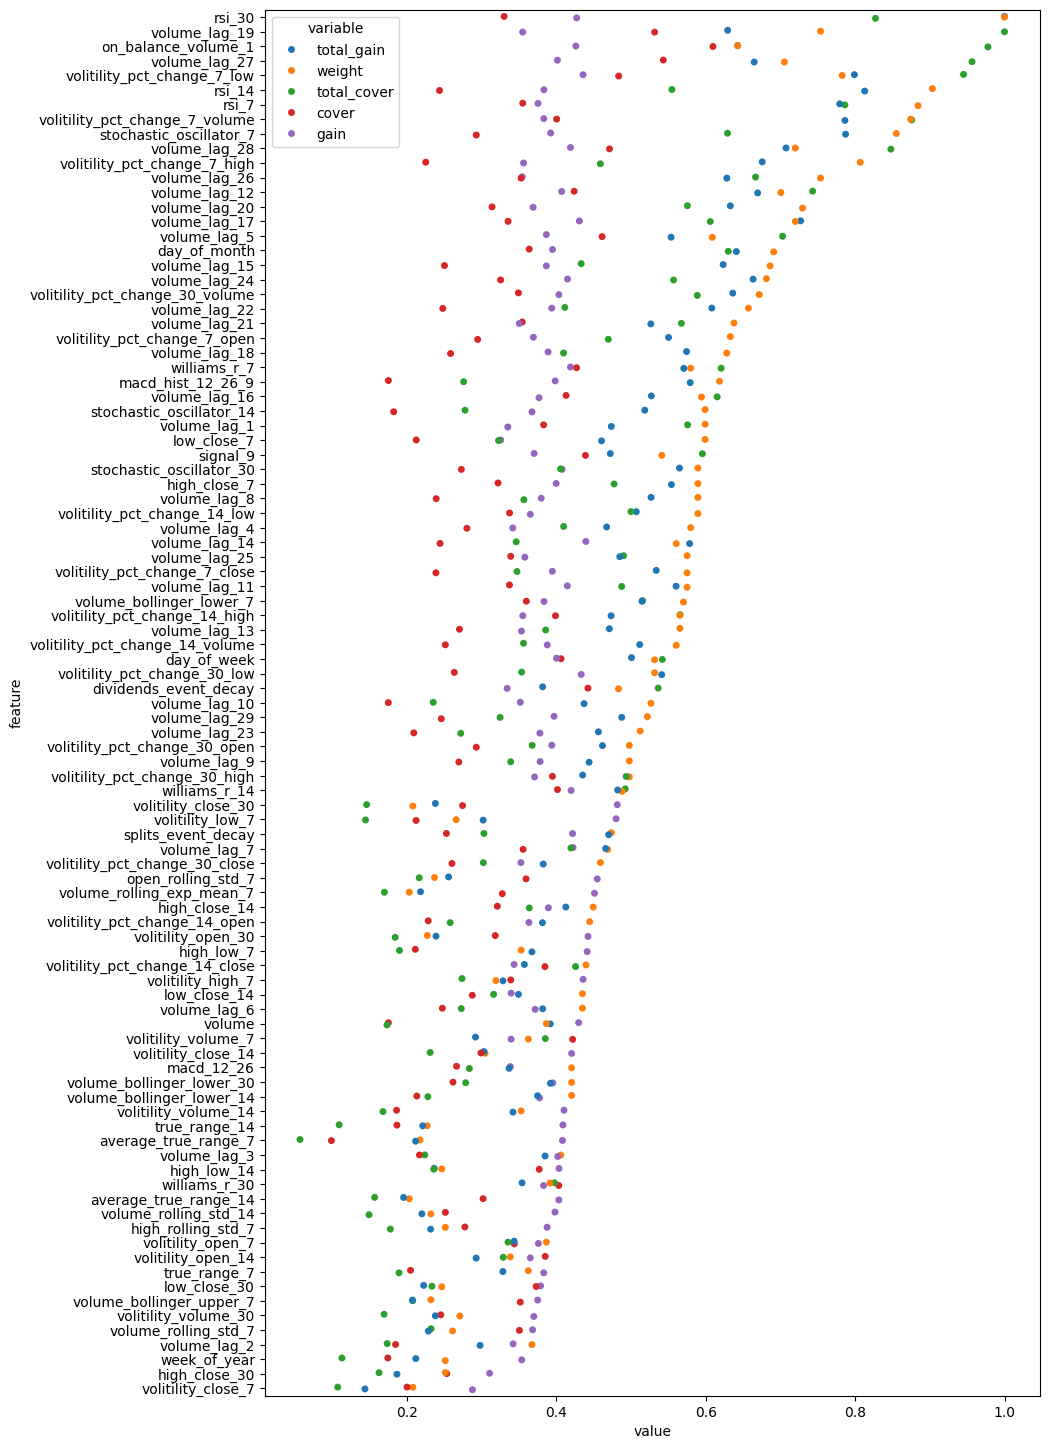

In [22]:
fig, ax = plt.subplots(figsize=(10, 18))
sns.stripplot(
    df_importance[df_importance["weight"] >= 0.2]
    .melt(id_vars=["feature"], value_vars=importance_types).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
    jitter=True,
    legend="auto",
)

<Axes: xlabel='value', ylabel='feature'>

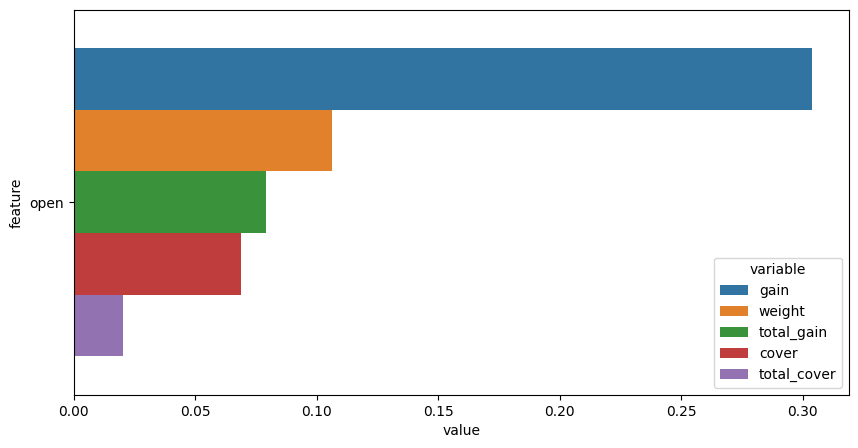

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    df_importance[df_importance["feature"] == "open"]
    .melt(id_vars=["feature"], value_vars=importance_types).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
)

<Axes: xlabel='value', ylabel='feature'>

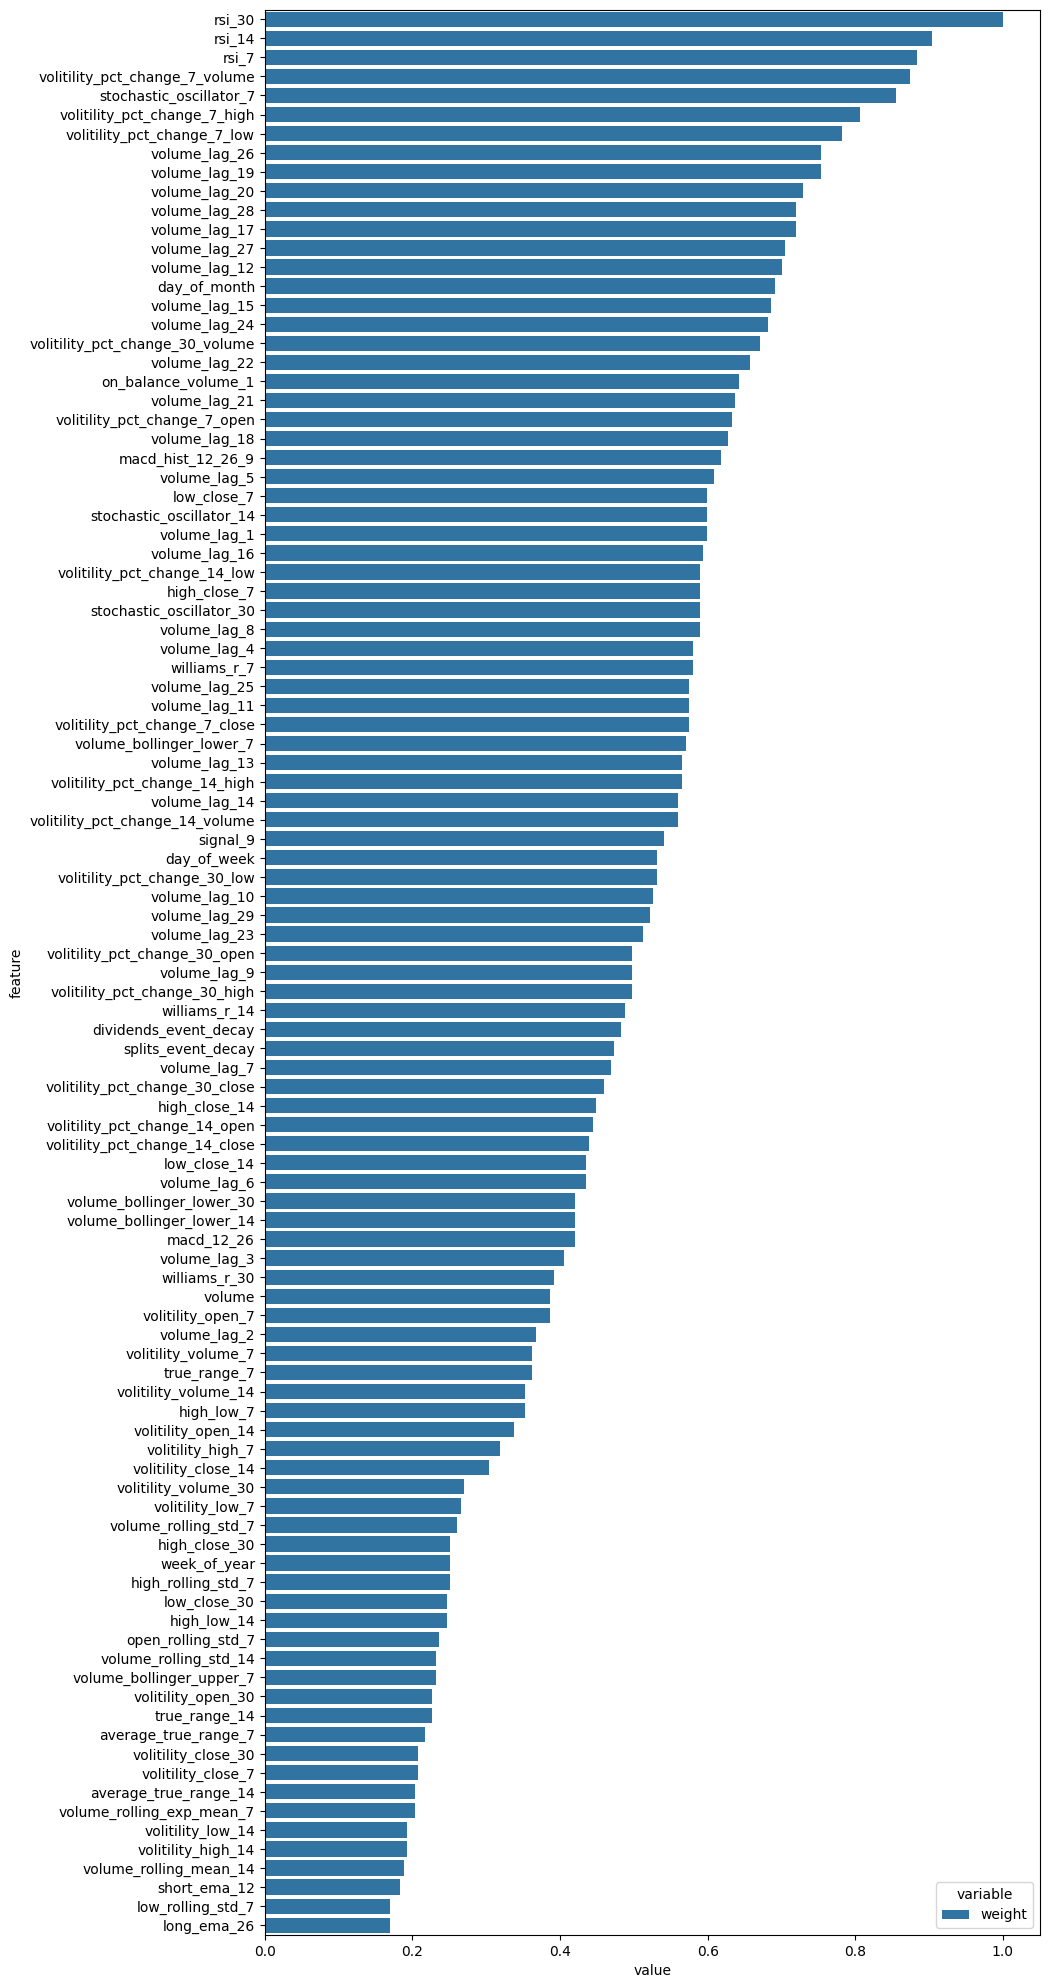

In [24]:
fig, ax = plt.subplots(figsize=(10, 25))
sns.barplot(
    df_importance[df_importance["weight"] >= 0.15][["feature", "weight"]]
    .melt(id_vars=["feature"], value_vars=["weight"]).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
)

<Axes: xlabel='value', ylabel='feature'>

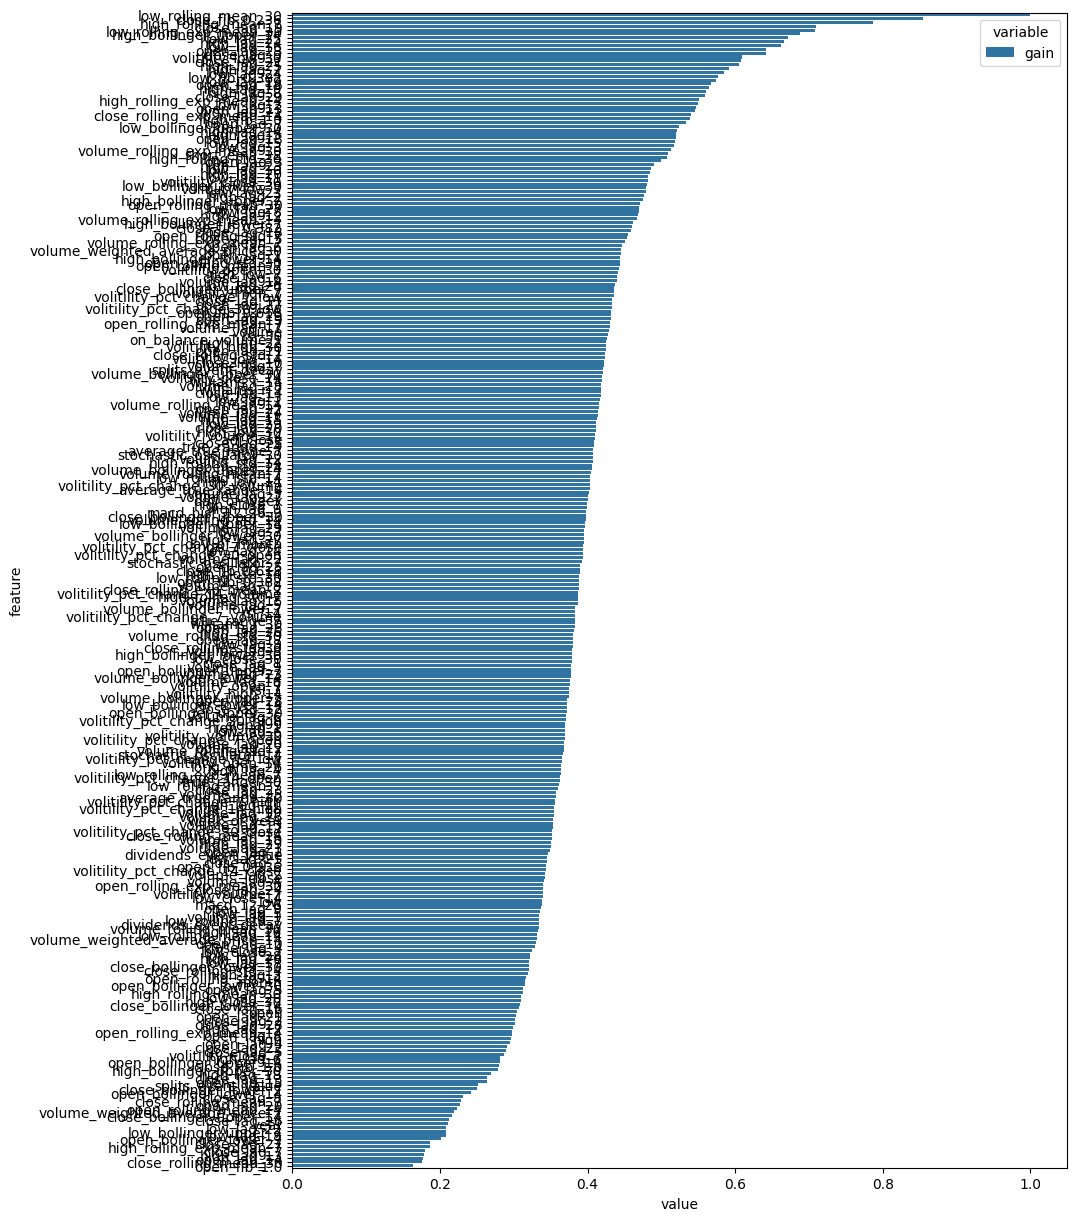

In [25]:
fig, ax = plt.subplots(figsize=(10, 15))
sns.barplot(
    df_importance[df_importance["gain"] >= 0.15][["feature", "gain"]]
    .melt(id_vars=["feature"], value_vars=["gain"]).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
)

<Axes: xlabel='value', ylabel='feature'>

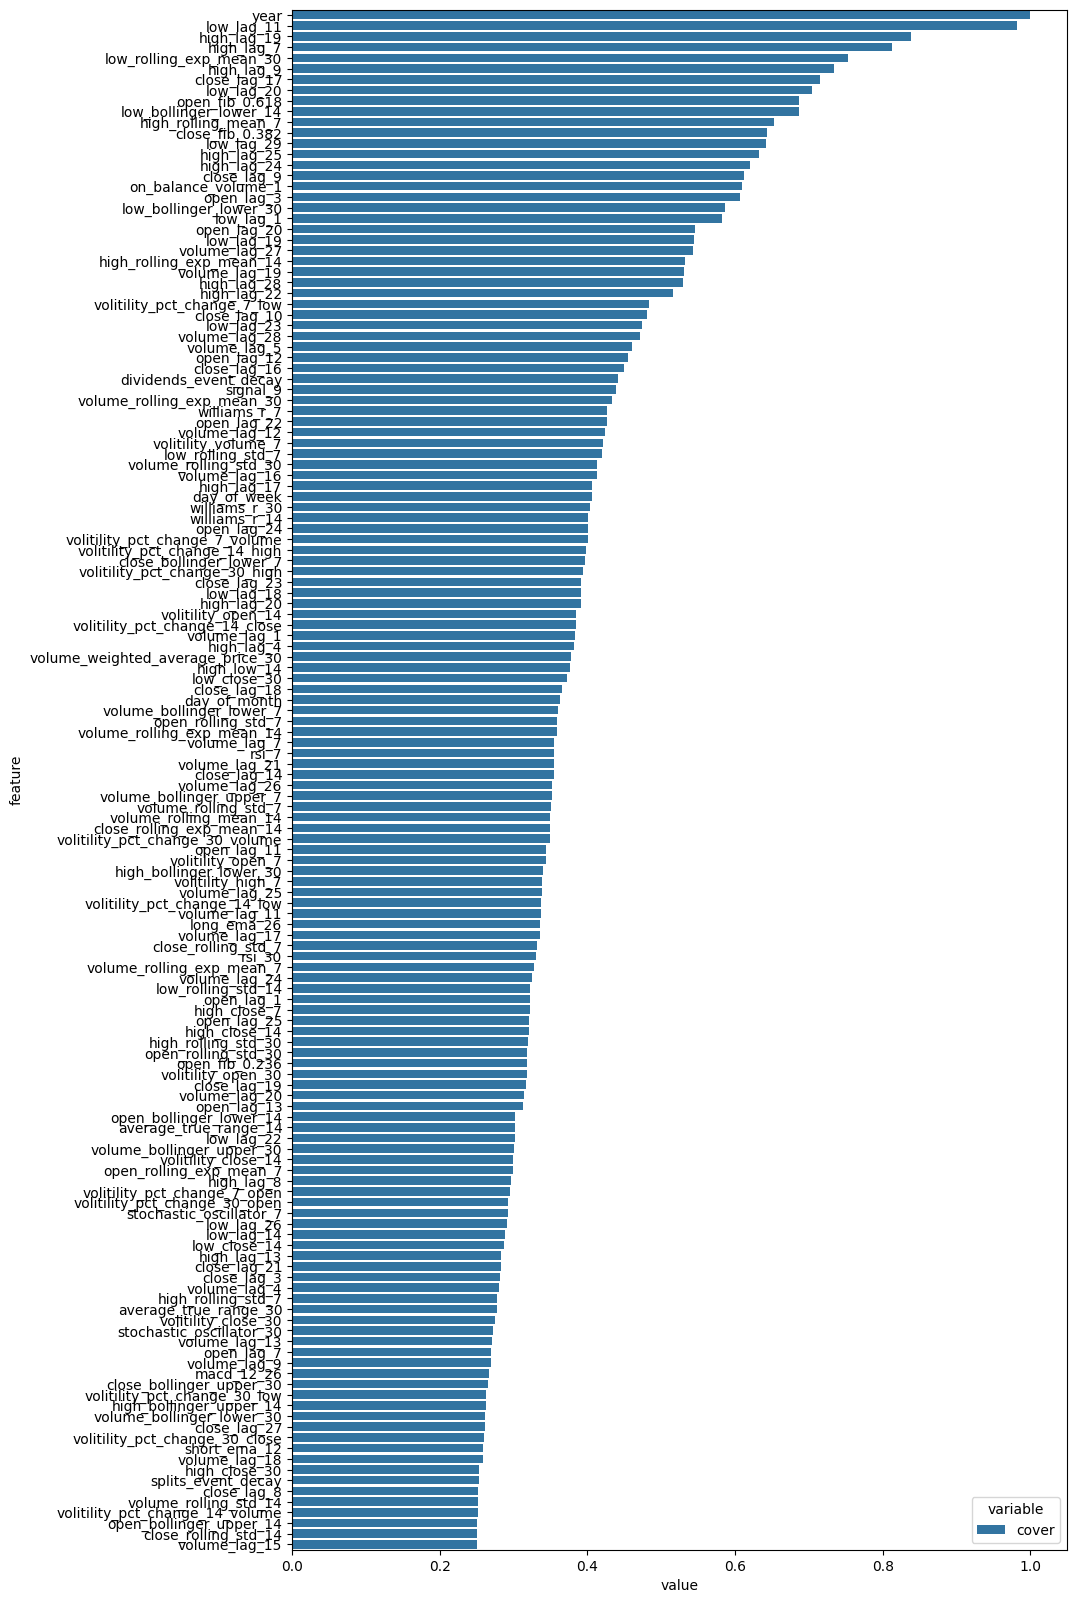

In [26]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.barplot(
    df_importance[df_importance["cover"] >= 0.25][["feature", "cover"]]
    .melt(id_vars=["feature"], value_vars=["cover"]).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
)